In [1]:
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import cv2
from pathlib import Path
import keras
import tensorflow_datasets as tfds
from keras import layers
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization , Input , Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from google.colab import drive
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.layers import Rescaling 
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
from tensorflow.keras.layers import LeakyReLU






def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score)
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

folder = '/kaggle/input/d/dhaks13/brain-tumor-segmentation/data/Glioma'


def natural_sort(item):
    numbers = re.findall(r'\d+', item)
    
    return int(numbers[-1]) if numbers else 0


mask_list = []
image_list = []
for paths, dirs, files in os.walk(folder):
    for file in files:
        if 'mask' in file:
             mask_list.append(os.path.join(paths, file))

             mask_list.sort(key = natural_sort )

        else :
              image_list.append(os.path.join(paths, file))

              image_list.sort(key= natural_sort)


print(len(image_list))
print(len(mask_list))


image_list = [tf.keras.preprocessing.image.load_img(i) for i in image_list]
image_list = [tf.image.resize(i, (200, 200)) for i in image_list]


mask_list = [tf.keras.preprocessing.image.load_img(i) for i in mask_list]
mask_list = [tf.image.resize(i, (200, 200)) for i in mask_list]
mask_list = [tf.image.rgb_to_grayscale (i) for i in mask_list]


image_array = np.array([np.array(img) for img in image_list])
mask_array = np.array([np.array(mask)/255.0 for mask in mask_list])
mask_array = (mask_array > 0.5).astype(np.float32)
print(len(image_list))
print(len(mask_list))
print(np.unique(mask_array))  


ddata = tf.data.Dataset.from_tensor_slices((image_array,mask_array))



ddata = ddata.shuffle(buffer_size=1000, seed=None)


total_size = len(ddata)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  


train_ds = ddata.take(train_size)
remaining = ddata.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)


train_ds = train_ds.batch(10)
val_ds = val_ds.batch(10)
test_ds = test_ds.batch(10)


print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")



from tensorflow.keras.optimizers import Adam
opti = Adam(learning_rate=1e-4)
dice_loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size', name='dice'
)
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * dice + 0.5 * bce

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


1426
1426
1426
1426
[0. 1.]
Train size: 998
Validation size: 213
Test size: 215


In [2]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - iou: 0.0910 - loss: 0.4852 - val_iou: 0.0304 - val_loss: 0.6416
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 666ms/step - iou: 0.2952 - loss: 0.3035 - val_iou: 0.0474 - val_loss: 0.5554
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 664ms/step - iou: 0.3742 - loss: 0.2597 - val_iou: 0.0799 - val_loss: 0.5643
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 665ms/step - iou: 0.4386 - loss: 0.2315 - val_iou: 0.2249 - val_loss: 0.3857
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - iou: 0.4668 - loss: 0.2089 - val_iou: 0.3002 - val_loss: 0.3273
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - iou: 0.5215 - loss: 0.1845 - val_iou: 0.3844 - val_loss: 0.2764
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - iou: 0.4992 - loss: 0.1913 - val_iou: 0.4520 - val_loss: 0.2109
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - iou: 0.5679 - loss: 0.1548 - val_iou: 0.5000 - val_loss: 0.2017
Epoch 9/100
100/100 ━━━━━━

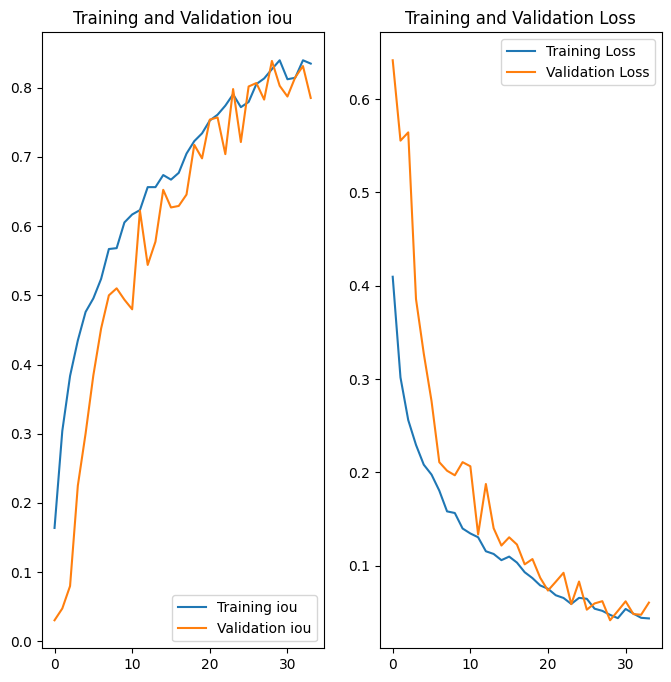

In [3]:
input = Input(shape=(200,200,3))
q = Rescaling(1.0 / 255)(input)



a = layers.Conv2D(64 , 3, padding = 'same', kernel_initializer = 'he_normal', activation = mish)(q)
a_2 = layers.Conv2D(128 , 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(a)
a_3 = BatchNormalization()(a_2)
a_4 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(a_3)





b = layers.Conv2D(64 , 5, padding = 'same', kernel_initializer = 'he_normal', activation = mish)(q)
b_2 = layers.Conv2D(128 , 5, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(b)
b_3 = BatchNormalization()(b_2)
b_4 =  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(b_3)







x = layers.concatenate([a_4,b_4])
x_1 = layers.Conv2D(256 , 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(x)
x_1a = layers.Conv2D(512 , 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(x_1)
x_1b = BatchNormalization()(x_1a)
x_1c = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x_1b)


f_1 = layers.Conv2D(1024 , 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(x_1c)
f_1b = BatchNormalization()(f_1)
f_1c =  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(f_1b)



f_2 = layers.Conv2D(1024 , 3, padding = 'same', kernel_initializer = 'he_normal', activation = mish )(x_1c)
f_2b = BatchNormalization()(f_2)
f_2c =  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(f_2b)


f_3 = tf.keras.layers.SeparableConv2D(1024, 3, strides = 1 ,padding='same', activation='relu')(x_1c)
f_3b = BatchNormalization()(f_3)
f_3c = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid") (f_3b)


f_4 = tf.keras.layers.SeparableConv2D(1024, 3, strides=(1, 1),padding='same', activation= mish )(x_1c)
f_4b = BatchNormalization()(f_4)
f_4c =  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(f_4b)

g = layers.concatenate([f_1c,f_2c,f_3c,f_4c])
g_1 = layers.Conv2DTranspose(  512,  3 ,  strides=(2, 2),  padding="same" )(g)

g_2  = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= 'relu')(g_1)
g_3  = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= 'relu')(g_2)

g_4 = layers.Conv2DTranspose(  256,  3 ,  strides=(2, 2),  padding="same" )(g_3)
gamma = layers.concatenate([g_4,x])
g_5  = layers.Conv2D(256 , 3, padding='same',kernel_initializer='he_normal', activation= 'relu')(gamma)
g_6  = layers.Conv2D(256 , 3, padding='same',kernel_initializer='he_normal', activation= 'relu')(g_5)

g_7 = layers.Conv2DTranspose(  128,  3 ,  strides=(2, 2),  padding="same" )(g_6)

g_8  = layers.Conv2D(128 , 3, padding='same',kernel_initializer='he_normal', activation= 'relu')(g_7)
g_9  = layers.Conv2D(128 , 3, padding='same',kernel_initializer='he_normal', activation= 'relu')(g_8)

outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(g_9)
model = keras.Model(inputs=input, outputs=outputs)

epochs= 100
model.compile(optimizer=opti,
              loss= combined_loss  ,
              metrics=[iou])
history = model.fit(
  train_ds,
  validation_data=val_ds,
   epochs=epochs ,callbacks = early_stopping )
acc = history.history['iou']
val_acc = history.history['val_iou']

loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training iou')
plt.plot( val_acc, label='Validation iou')
plt.legend(loc='lower right')
plt.title('Training and Validation iou')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


     









In [8]:
model.save('visualnet1.keras')

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - iou: 0.7934 - loss: 0.0654
Test Loss: 0.05194545537233353
Test IoU: 0.8134772777557373
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step


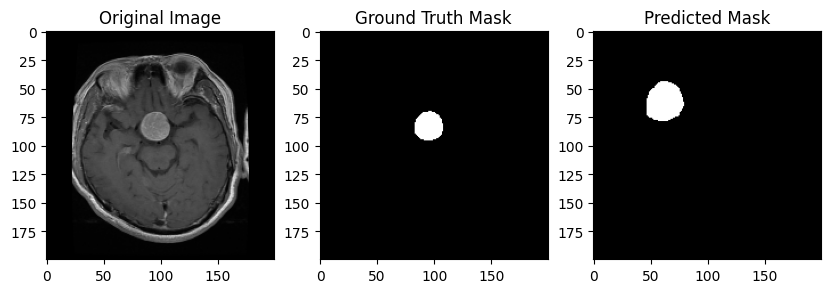

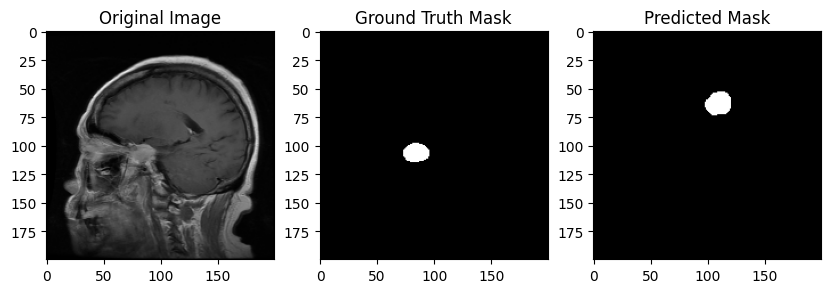

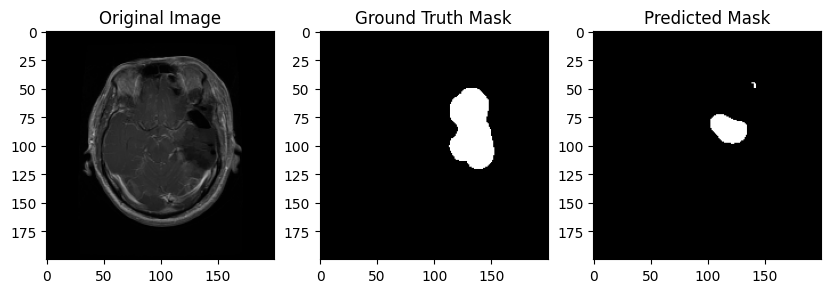

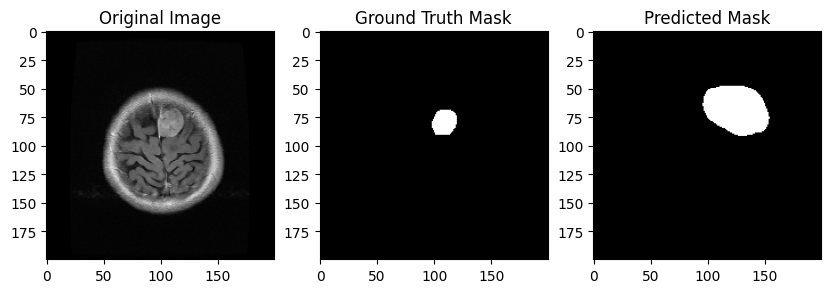

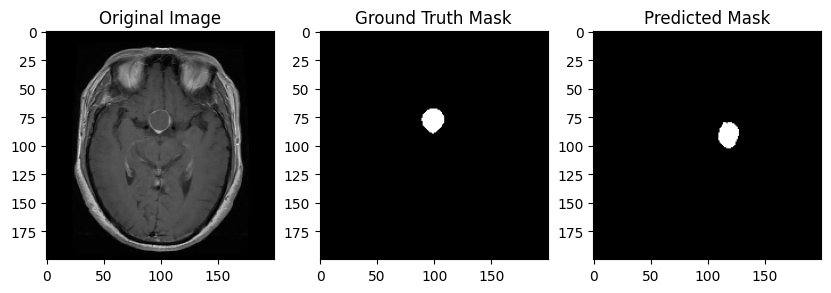

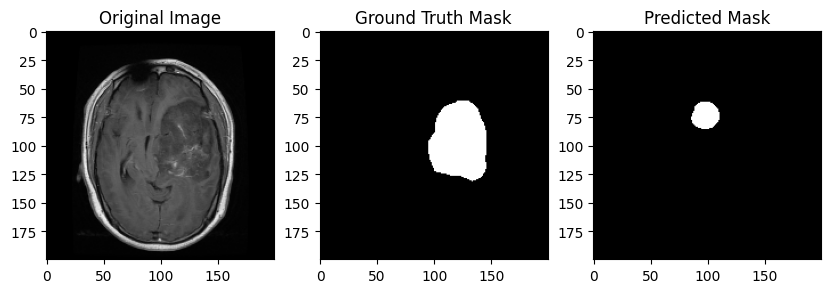

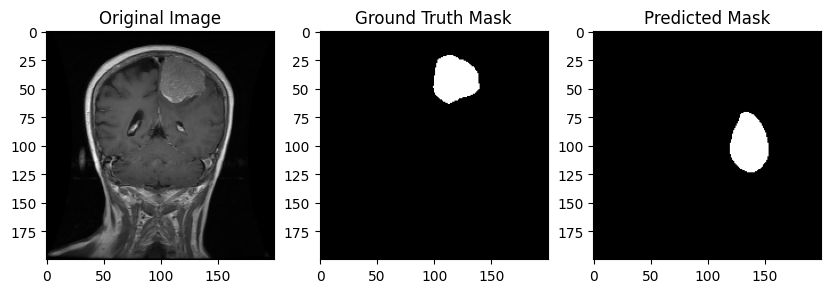

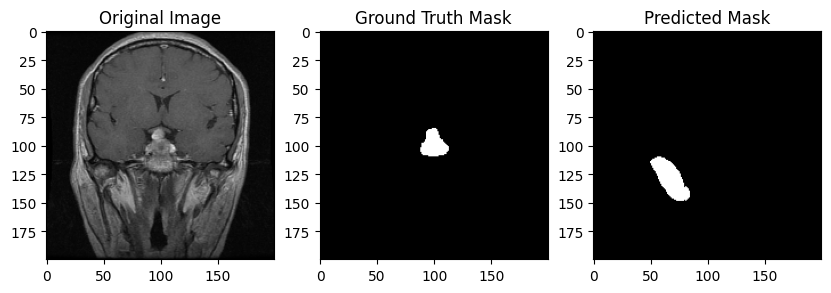

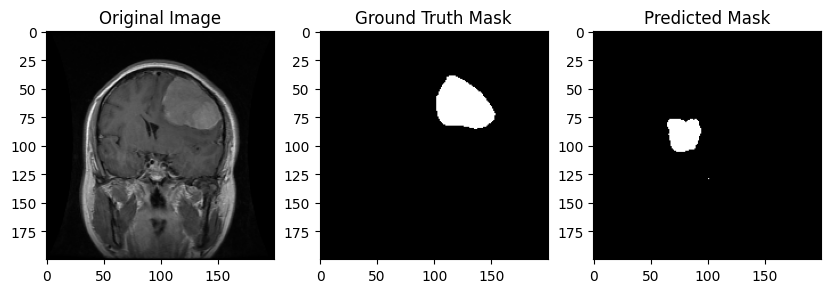

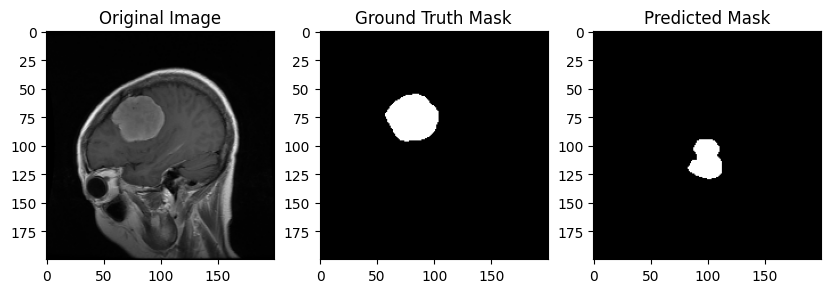

In [7]:

test_loss, test_iou = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test IoU: {test_iou}")

predictions = model.predict(test_ds)


binary_predictions = (predictions > 0.5).astype(np.float32)

test_images, test_masks = next(iter(test_ds))  
test_images = test_images.numpy()
test_masks = test_masks.numpy()

import matplotlib.pyplot as plt

for i in range(min(10, len(test_images))):  
    plt.figure(figsize=(10, 10))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].astype(np.uint8))
    plt.title("Original Image")

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")

    plt.show()
